### Data Understanding

Understand the Business Context

You are a new intern at SimbaCorp. Your supervisor says:

“We’ve had too many cases of either running out of critical parts or sitting on old inventory. Can you use our sales history to help us know what to stock and when?”

You’ll solve this by:

- Forecasting monthly demand of each part

- Recommending reorder quantity and timing

- Visualizing it clearly

Columns In The Dataset

Column Name	            Description
invoice_date	        Date of invoice – likely the sale date of the part
job_card_date	        Date of service job creation
business_partner_name	The customer or partner's name
vehicle_no	            The vehicle serviced
vehicle_model	        Model of the vehicle
current_km_reading	    Odometer reading at time of service
invoice_line_text	    Name/description of the part (e.g., "Air Filter")
	
Data Volume
•	Total Rows: 28,482
•	Missing Values: invoice_line_text has 34 nulls (we’ll handle these in cleaning)
•	Date Format: Dates are currently in object type → need to convert to datetime
•	Time Granularity: Daily (per invoice) — we will aggregate to monthly


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

### Data Preprocessing

In [2]:
df= pd.read_csv(r'C:\Users\JAQUE\Documents\Inventory-Management-Demand-Using-Time-Series-Analysis-and-Forecasting\inventory.csv')
df.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [3]:
# Data Structure

df.shape

(28482, 7)

In [4]:
# Data Columns

df.columns

Index(['invoice_date', 'job_card_date', 'business_partner_name', 'vehicle_no',
       'vehicle_model', 'current_km_reading', 'invoice_line_text'],
      dtype='object')

In [5]:
# Data Datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  int64 
 6   invoice_line_text      28448 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


In [6]:
# Integer Description

df.describe()

,current_km_reading
count,28482.000000
mean,19348.003827
std,25246.722306
min,0.000000
25%,3988.000000
50%,12420.500000
75%,27905.000000
max,610112.000000


In [7]:
# Checking For Null Values

df.isnull().sum()

invoice_date              0
job_card_date             0
business_partner_name     0
vehicle_no                0
vehicle_model             0
current_km_reading        0
invoice_line_text        34
dtype: int64

The column invoice_line_text which represents our different orders appears to have 34 missing values

In [8]:
# Convert (invoice_date & job_card_date)to datetime

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['job_card_date'] = pd.to_datetime(df['job_card_date'])

In [9]:
df.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,2017-05-30,2017-05-30,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,2017-02-06,2017-05-31,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,2017-02-06,2017-05-31,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,2017-02-06,2017-05-31,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,2017-02-06,2017-05-31,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [10]:
# Extract year and months

df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month_name()

In [11]:
# Handling Missing Values

df['invoice_line_text'] = df['invoice_line_text'].fillna('UNKNOWN PART')

In [12]:
df['invoice_line_text'].value_counts().loc['UNKNOWN PART']

34

In [13]:
# Cleaning For Consistency

df['invoice_line_text'] = df['invoice_line_text'].str.strip().str.upper()

In [14]:
# Unit Level Sales Computation

# Count each part entry (each row = 1 unit)
df['units_sold'] = 1

# Total units sold per part
total_units = df.groupby('invoice_line_text')['units_sold'].sum().reset_index()
total_units


,invoice_line_text,units_sold
0,10 SIZE NUT,2
1,12 SIZE BOLT,2
2,3M OIL,1628
3,4 WAY SWITCH,2
4,6004 BEARING,2
...,...,...
489,WIRING LABOUR,4
490,YOKE,21
491,YOKE LEVER,2
492,YOKE RUBBER,4


In [15]:
df.to_csv('output.csv', index=False)


### Exploratory Data Analysis

#### EDA Goals
- Understand overall part demand trends

- Identify high-demand vs low-demand parts

- Analyze seasonality (monthly/yearly patterns)

- Spot irregularities or outliers in demand

- Evaluate demand by vehicle model 

Insight Type	        What to Watch

Trend	                Is total demand increasing/decreasing over time?
Seasonality	            Are there peak months across years (e.g., Jan, June)?
High-Volume Parts	    Which parts dominate demand volume?
Volatility	            Are some parts highly inconsistent month to month?
Gaps	                Any months with abnormally low sales (COVID impact, system change, etc.)

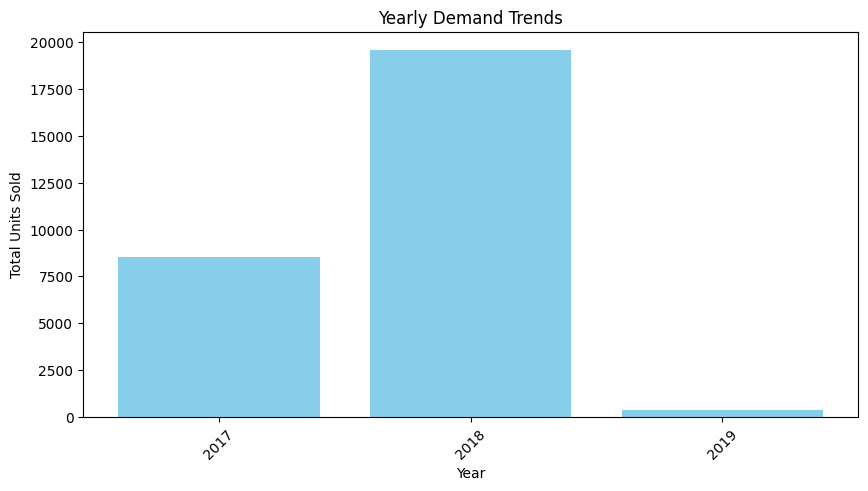

In [16]:
# Grouping by year to analyze overall yearly demand trends
#annual_demand = df.groupby('year').agg({'units_sold': 'sum'}).reset_index()
annual_demand = df.groupby('year')['units_sold'].sum().reset_index()
# Plotting the yearly demand trends
plt.figure(figsize=(10, 5))
plt.bar(annual_demand['year'].astype(str), annual_demand['units_sold'], color='skyblue')
plt.title('Yearly Demand Trends')
plt.xlabel('Year')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
# plt.grid(axis='y')
plt.show()

The bar chart illustrates the total units sold for each year.
You can observe trends in demand over the years, identifying any increases or decreases in sales.
Significant spikes or drops in certain years may indicate irregularities or outliers in demand, possibly due to external factors such as market changes, economic conditions, or changes in consumer behavior.

In [17]:
#### 2. Total Monthly Demand By Year
# Grouping by month and year to analyze demand trends

# Define the calendar month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert month to a categorical type with the defined order
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

# Now group and sort correctly
monthly_demand_by_year = df.groupby(['year', 'month'])['units_sold'].sum().reset_index()
monthly_demand_by_year = monthly_demand_by_year.sort_values(by=['year', 'month'])

monthly_demand_by_year.head(10)

,year,month,units_sold
0,2017,January,377
1,2017,February,254
2,2017,March,240
3,2017,April,336
4,2017,May,248
5,2017,June,1106
6,2017,July,1006
7,2017,August,864
8,2017,September,985
9,2017,October,879


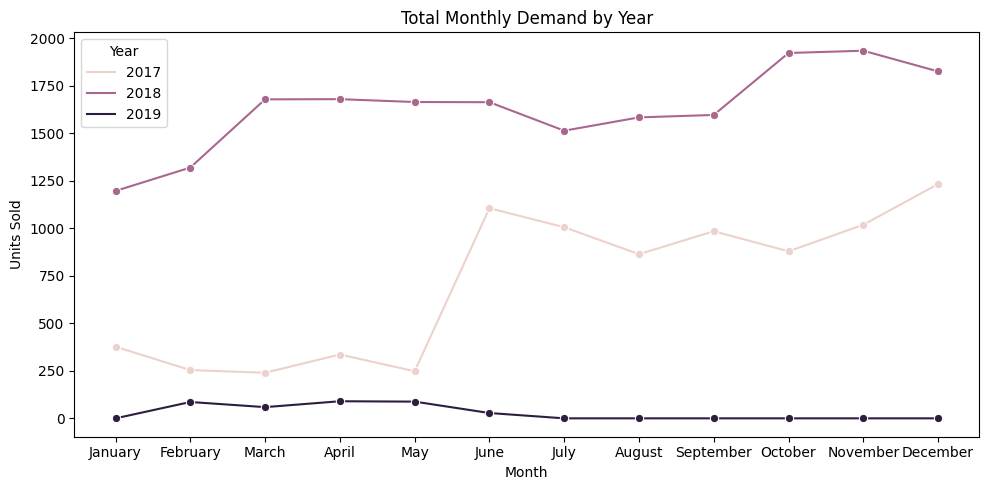

In [18]:
#### Plot Total Monthly Demand Across All Parts By Year

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=monthly_demand_by_year,
    x='month',
    y='units_sold',
    hue='year',
    marker='o'
)
plt.title('Total Monthly Demand by Year')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.grid(False)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

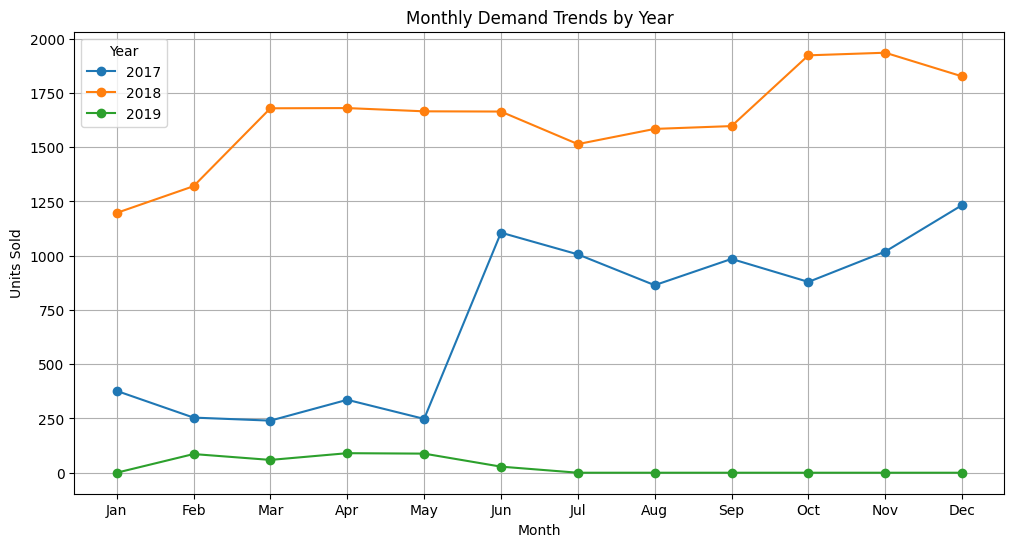

In [19]:
#### Plot Total Monthly Demand Across All Parts By Year

# Creating a pivot table for better visualization
monthly_demand_pivot = monthly_demand_by_year.pivot(index='month', columns='year', values='units_sold')

# Plotting the monthly demand trends
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_demand_pivot.index, monthly_demand_pivot.values, marker='o')
plt.title('Monthly Demand Trends by Year')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.xticks(monthly_demand_pivot.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(monthly_demand_pivot.columns, title='Year')
plt.grid()
plt.show()

The chart illustrates the total units sold for each month across different years.
Peaks in demand can be observed during certain months, indicating seasonal trends. 
Conversely, some months may show lower sales, indicating potential off-peak periods.

In [20]:
#### 2. Total Monthly Demand By Part

monthly_demand_by_part = df.groupby(['invoice_line_text', 'month'])['units_sold'].sum().reset_index()
monthly_demand_by_part


,invoice_line_text,month,units_sold
0,10 SIZE NUT,January,0
1,10 SIZE NUT,February,0
2,10 SIZE NUT,March,0
3,10 SIZE NUT,April,0
4,10 SIZE NUT,May,0
...,...,...,...
5923,YOKE SET,August,0
5924,YOKE SET,September,0
5925,YOKE SET,October,0
5926,YOKE SET,November,0


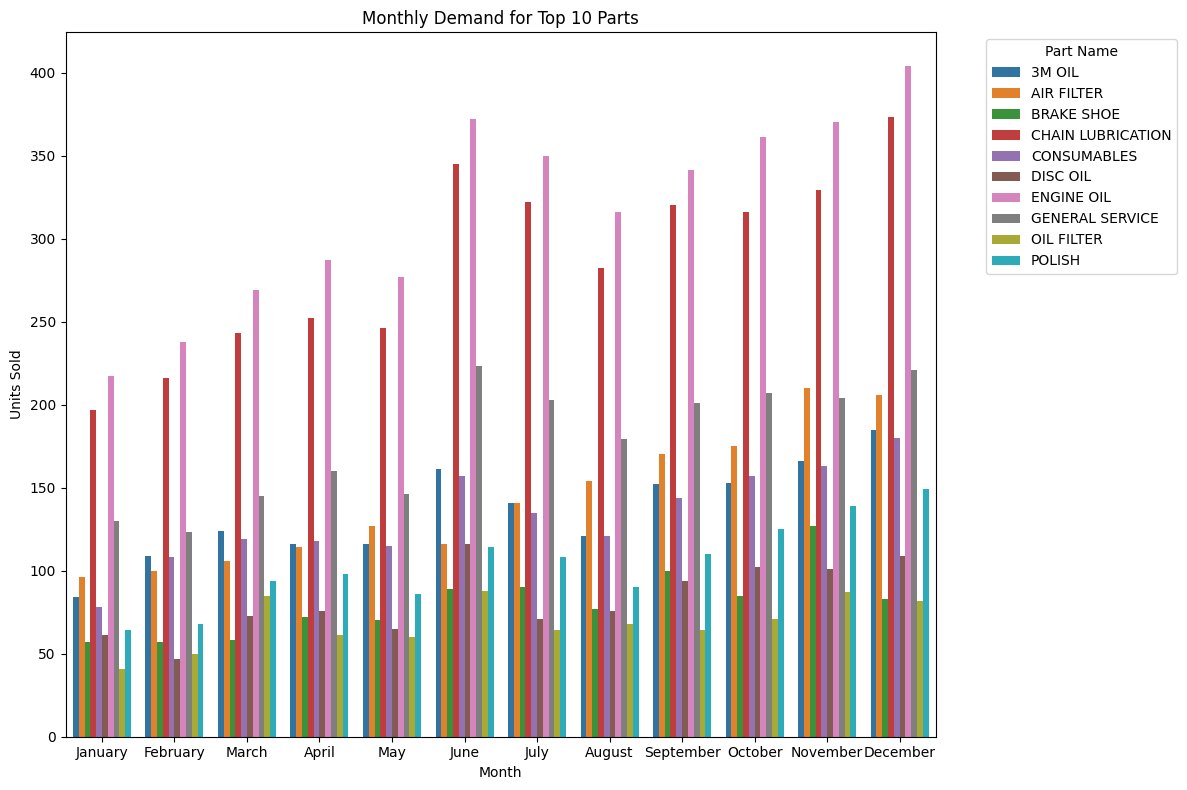

In [21]:
#### Plot Monthly Demand Broken Down By Part

# Since there are too many unique parts, to avoid overcrowding, we'll pick the top 10 parts
# Step 1: Get top 10 most sold parts
top_parts = df.groupby('invoice_line_text')['units_sold'].sum().nlargest(10).index

# Step 2: Filter data
filtered_df = df[df['invoice_line_text'].isin(top_parts)]

# Step 3: Group again
monthly_demand_top_parts = filtered_df.groupby(['invoice_line_text', 'month'])['units_sold'].sum().reset_index()

# Step 4: Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=monthly_demand_top_parts,
    x='month',
    y='units_sold',
    hue='invoice_line_text'
)
plt.title('Monthly Demand for Top 10 Parts')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.legend(title='Part Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


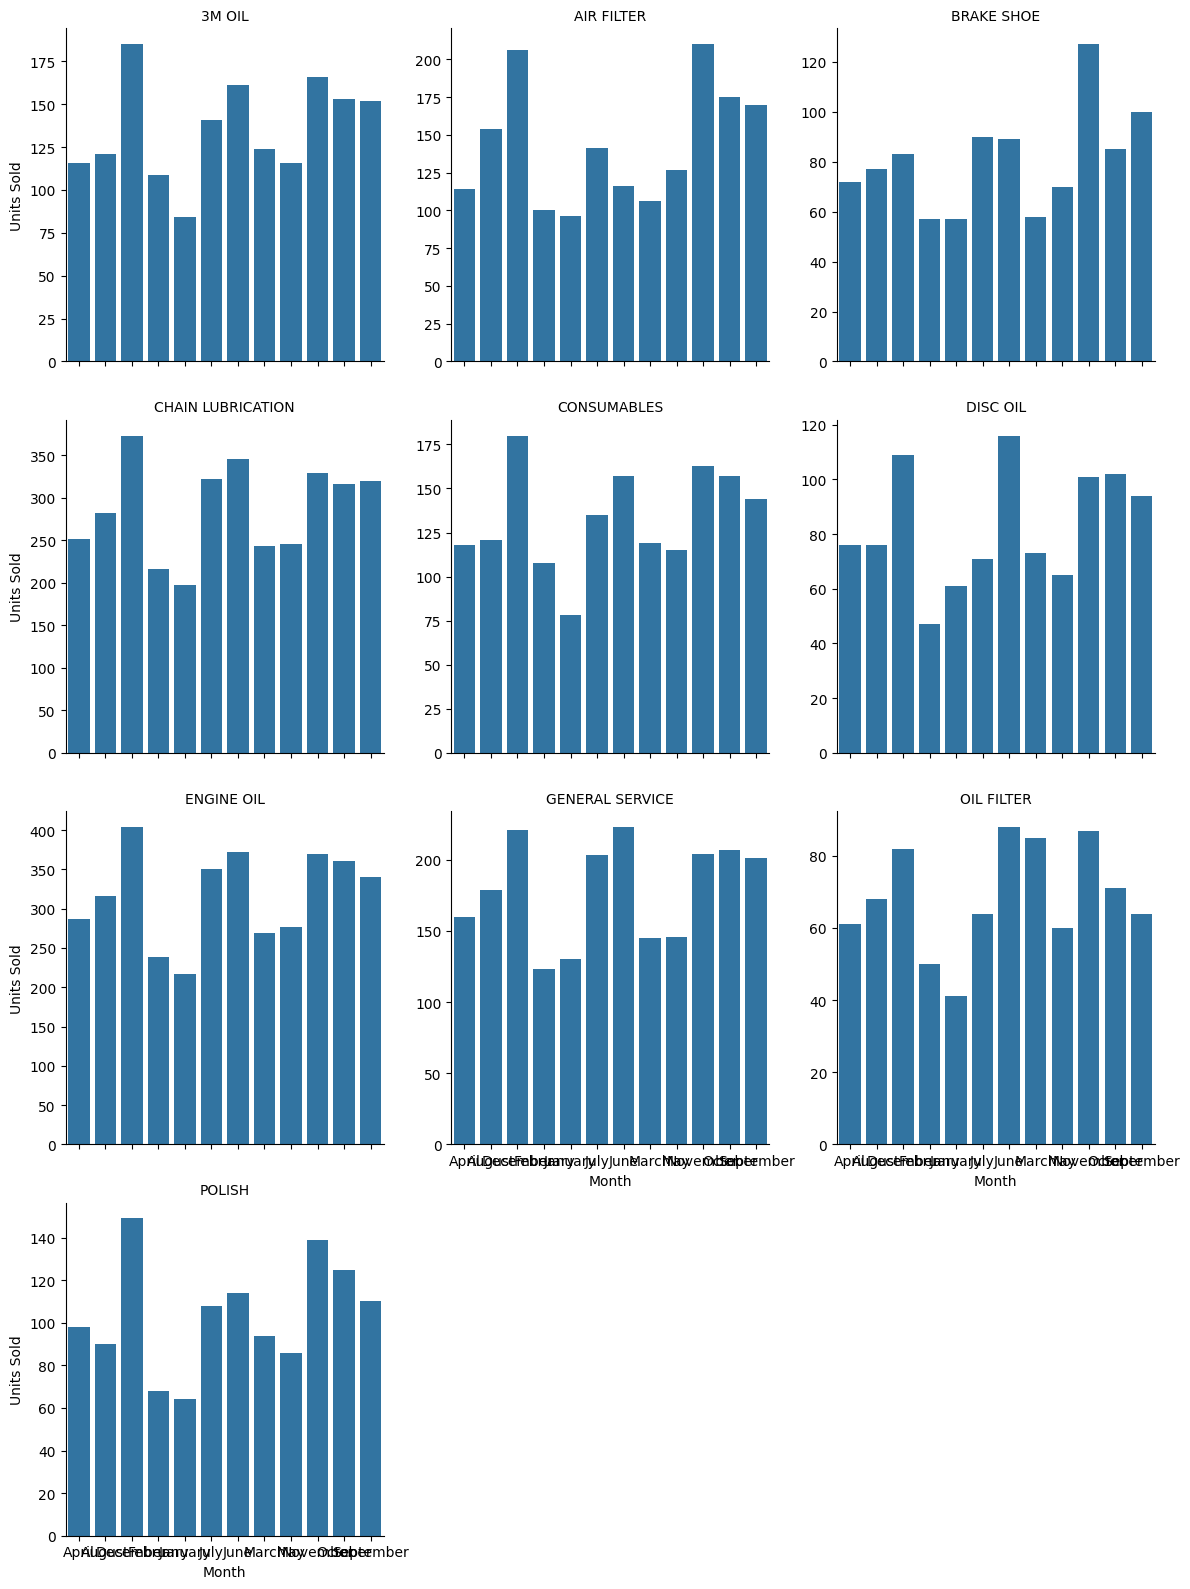

In [22]:

# Filter top parts
top_parts_df = df[df['invoice_line_text'].isin(top_parts)]

# Group
grouped = top_parts_df.groupby(['invoice_line_text', 'month'])['units_sold'].sum().reset_index()

# Plot using FacetGrid
g = sns.FacetGrid(grouped, col="invoice_line_text", col_wrap=3, height=4, sharey=False)
g.map(sns.barplot, 'month', 'units_sold', order=sorted(df['month'].unique()))
g.set_titles("{col_name}")
g.set_axis_labels("Month", "Units Sold")
plt.tight_layout()
plt.show()


In [23]:
# Grouping by part to identify the highest-selling parts
highest_selling_parts = df.groupby('invoice_line_text').agg({'units_sold': 'sum'}).reset_index()
highest_selling_parts = highest_selling_parts.sort_values(by='units_sold', ascending=False).head(10)

# Displaying the highest-selling parts
highest_selling_parts.head(10)

,invoice_line_text,units_sold
144,ENGINE OIL,3802
74,CHAIN LUBRICATION,3441
205,GENERAL SERVICE,2142
10,AIR FILTER,1715
2,3M OIL,1628
106,CONSUMABLES,1595
342,POLISH,1245
121,DISC OIL,991
45,BRAKE SHOE,965
314,OIL FILTER,821


In [24]:
# Pivoting the data for visualization
monthly_part_demand_pivot = monthly_part_demand.pivot(index='month', columns='invoice_line_text', values='units_sold')

# Plotting the monthly trends for the top-selling parts
plt.figure(figsize=(12, 8))
for part in highest_selling_parts['invoice_line_text']:
    if part in monthly_part_demand_pivot.columns:
        plt.plot(monthly_part_demand_pivot.index, monthly_part_demand_pivot[part], marker='o', label=part)

plt.title('Monthly Demand Trends for Highest-Selling Parts')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.xticks(monthly_part_demand_pivot.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Parts')
plt.grid()
plt.show()

NameError: name 'monthly_part_demand' is not defined

In [26]:
df['invoice_line_text'].nunique()

494

In [27]:
# printing all items from invoice_line_text
for item in df.invoice_line_text.unique():
    print(f"'{item}',")

'ENGINE OIL',
'POLISH',
'CONSUMABLES',
'COOLANT OIL',
'CHAIN LUBRICATION',
'4 WAY SWITCH',
'3M OIL',
'GENERAL SERVICE',
'OIL FILTER',
'INDICATOR',
'HEAD REST',
'VALVE GUIDE',
'TIMMING CHAIN',
'FOOT REST',
'LOW BEAM BULB',
'VALVE GRAINDING',
'DISC PAD',
'LOADING GEAR',
'PACKING KIT',
'TIMMING CHAIN PAD',
'TENSIONER',
'CLUTCH BELL REST',
'CLUTCH ASSEMBLY',
'VALVE KIT',
'SPARK PLUG',
'ONE WAY CLUTCH',
'BORE KIT',
'AIR FILTER',
'HEAD RUBBER',
'CLUTCH CABLE',
'CRANK SHAFT',
'BRAKE ADJUSTMENT',
'BRAKE SHOE',
'AIR FILTER CHECKUP',
'DRUM BOLT WASHER',
'TANK CLEANING',
'FORK BEND',
'GEAR SHAFT',
'CLUTCH COVER GASKET',
'INDICATOR BULB',
'GEAR LEVER',
'HANDLEBAR',
'CRASH GUARD',
'FORK OIL SEAL',
'FORK OIL',
'SIDE SHIELD',
'VISIOR',
'FORK CONE SET',
'HEAD LIGHT DOOM',
'TANK ASSEMBLY',
'DISC LEVER',
'CARBURETOR CLEANING',
'SEAT COVER',
'BUZZER',
'TAIL LAMP BULB',
'DISC OIL',
'DISC OVERHUAL',
'MASTER ASSEMBLY',
'CHAIN COVER RUBBER',
'ENGINE GUARD',
'CLUTCH CAM',
'DOOM',
'WHEEL RUBBER',
'TIMMING CHAI

In [30]:
with open("invoice_items.txt", "w", encoding="utf-8") as f:
    for item in df['invoice_line_text'].unique():
        f.write(f"'{item}',\n")